In [114]:
# importar pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
#import matplotlib.pyplot as plt
import pickle

In [209]:
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

## Definir a frequência para a amostragem

In [295]:
# definir frequência a ser considerada no modelo
frequencia = '10D' # 7D 15D 2W 3W M

In [296]:
# calcular períodos que cabem em um ano
intervalo_ano = pd.date_range(start='2018-01-01', end='2019-01-01', freq=frequencia)
periodos_ano = len(intervalo_ano)
print('Frequência:', frequencia)
print('Períodos em um ano:', periodos_ano)

Frequência: 10D
Períodos em um ano: 37


## Carregar dados de entrada

In [297]:
prefixo_arquivos = ''
#prefixo_arquivos = 'https://github.com/hjort/ai-labs/raw/master/kaggle/serpro-weather/'

In [298]:
# carregar arquivo de dados de treino
train_data = pd.read_csv(prefixo_arquivos + 'weather-train.csv', index_col='date', parse_dates=['date'])
train_data.info()
train_data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1508 entries, 2012-10-01 to 2016-11-16
Data columns (total 1 columns):
temperature    1507 non-null float64
dtypes: float64(1)
memory usage: 23.6 KB


,temperature
date,
2012-10-01,11.036840
2012-10-02,14.340558
2012-10-03,14.518382
2012-10-04,16.820351
2012-10-05,16.948431


In [299]:
# carregar arquivo de dados de teste
test_data = pd.read_csv(prefixo_arquivos + 'weather-test.csv', index_col='date', parse_dates=['date'])
test_data.info()
test_data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 378 entries, 2016-11-17 to 2017-11-29
Empty DataFrame

""
date
2016-11-17
2016-11-18
2016-11-19
2016-11-20
2016-11-21


## Realizar transformações nos dados

In [300]:
# remover valores nulos
data = train_data.dropna()

# reduzir a quantidade de dados para a frequência
data = data.resample(frequencia).mean()

# filtrar período desejado
#data = data['2013-01':'2015-12']

# converter temperatura para Kelvin
#data['temperature'] += 273.15

data.head()

,temperature
date,
2012-10-01,11.547366
2012-10-11,10.495057
2012-10-21,11.165272
2012-10-31,3.705239
2012-11-10,5.833302


In [301]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 151 entries, 2012-10-01 to 2016-11-09
Data columns (total 1 columns):
temperature    151 non-null float64
dtypes: float64(1)
memory usage: 2.4 KB


In [302]:
data.describe()

,temperature
count,151.000000
mean,12.677617
std,10.857554
min,-11.855714
25%,3.812923
50%,13.788775
75%,22.326109
max,32.259000


## Criar e analisar a série temporal

In [303]:
# criar série temporal a partir do dataframe
ts = data['temperature']
ts = ts.asfreq(frequencia)
ts.head()

date
2012-10-01    11.547366
2012-10-11    10.495057
2012-10-21    11.165272
2012-10-31     3.705239
2012-11-10     5.833302
Freq: 10D, Name: temperature, dtype: float64

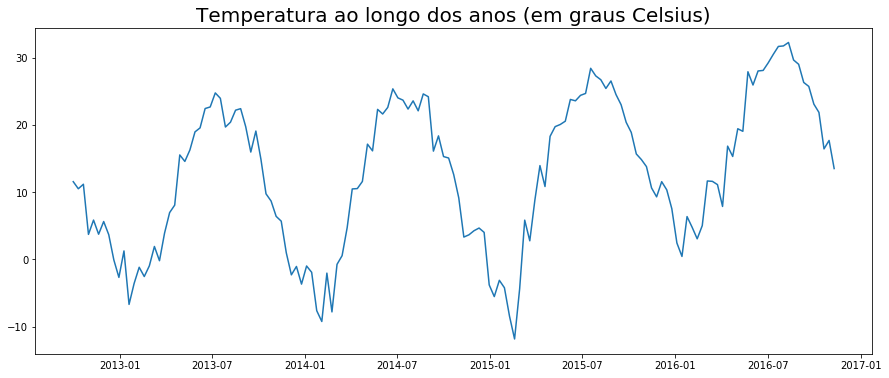

In [304]:
# plotar a série temporal
plt.plot(ts)
plt.title('Temperatura ao longo dos anos (em graus Celsius)', fontsize=20)
plt.show()

## Analisar estacionariedade

In [305]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries, window):
    
    # Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    # Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation', fontsize=20)
    plt.show(block=False)
    
    # Perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index=[
        'Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

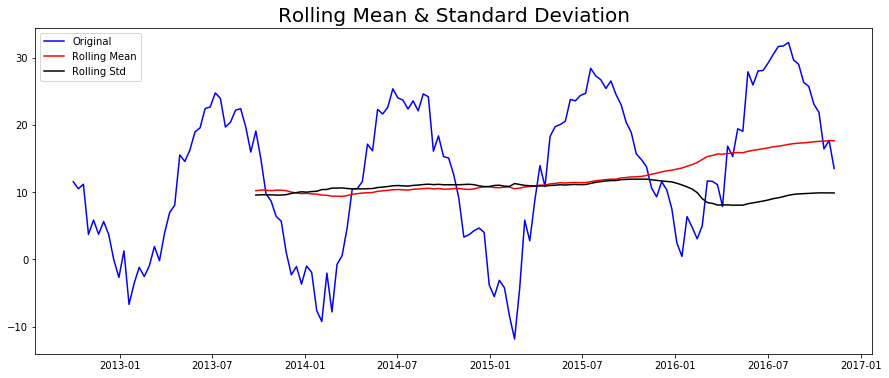

Results of Dickey-Fuller Test:
Test Statistic                  -5.516255
p-value                          0.000002
#Lags Used                       8.000000
Number of Observations Used    142.000000
Critical Value (1%)             -3.477262
Critical Value (5%)             -2.882118
Critical Value (10%)            -2.577743
dtype: float64


In [306]:
# avaliar se a série é estacionária
test_stationarity(ts, periodos_ano)

### Realizar testes para estimar parâmetros ARIMA

https://www.alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.ndiffs.html

In [307]:
from pmdarima.arima.utils import ndiffs

dft = pd.DataFrame({
    'Teste': [
        'ADF (Augmented Dickey-Fuller)',
        'KPSS (Kwiatkowski–Phillips–Schmidt–Shin)',
        'PP (Phillips–Perron)'
    ],
    'Valor estimado para o termo "d"': [
        ndiffs(ts, test='adf'),
        ndiffs(ts, test='kpss'),
        ndiffs(ts, test='pp')
    ]
})
dft.set_index('Teste', inplace=True)
dft

,"Valor estimado para o termo ""d"""
Teste,
ADF (Augmented Dickey-Fuller),0
KPSS (Kwiatkowski–Phillips–Schmidt–Shin),1
PP (Phillips–Perron),1


https://www.alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.nsdiffs.html

In [308]:
from pmdarima.arima.utils import nsdiffs

dft = pd.DataFrame({
    'Teste': [
        'OCSB (Osborn-Chui-Smith-Birchenhall)',
        'CH (Canova-Hansen)'
    ],
    'Valor estimado para o termo "D"': [
        nsdiffs(ts, periodos_ano, test='ocsb'),
        nsdiffs(ts, periodos_ano, test='ch')
    ]
})
dft.set_index('Teste', inplace=True)
dft

,"Valor estimado para o termo ""D"""
Teste,
OCSB (Osborn-Chui-Smith-Birchenhall),0
CH (Canova-Hansen),0


## Analisar componente de sazonalidade

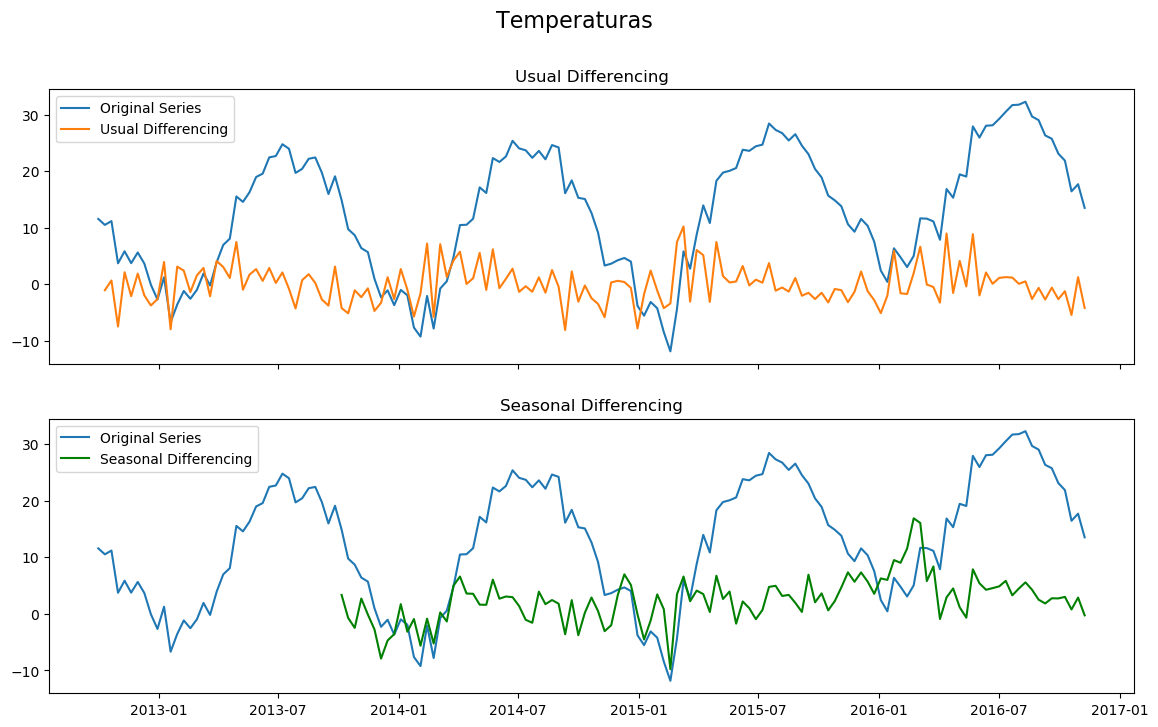

In [309]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(14,8), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(ts, label='Original Series')
axes[0].plot(ts.diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)

# Seasonal 1st
axes[1].plot(ts, label='Original Series')
axes[1].plot(ts.diff(periodos_ano), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Temperaturas', fontsize=16)
plt.show()

## Ajustar preditor ARIMA de forma automática
- https://www.alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

In [ ]:
from pmdarima import auto_arima

# Seasonal - fit stepwise auto-ARIMA
smodel = auto_arima(ts, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=periodos_ano,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 37); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 37); AIC=627.041, BIC=632.496, Fit time=12.871 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 37); AIC=602.342, BIC=613.252, Fit time=70.195 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 37); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 37); AIC=615.516, BIC=623.698, Fit time=8.978 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 37); AIC=596.068, BIC=609.705, Fit time=323.072 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 37); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 1, 0, 37); AIC=611.567, BIC=622.476, Fit time=134.679 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(2, 1, 0, 37); AIC=592.542, BIC=608.906, Fit time=291.356 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(2, 1, 0, 37); AIC=nan, BI

### Avaliar o resultado das previsões futuras

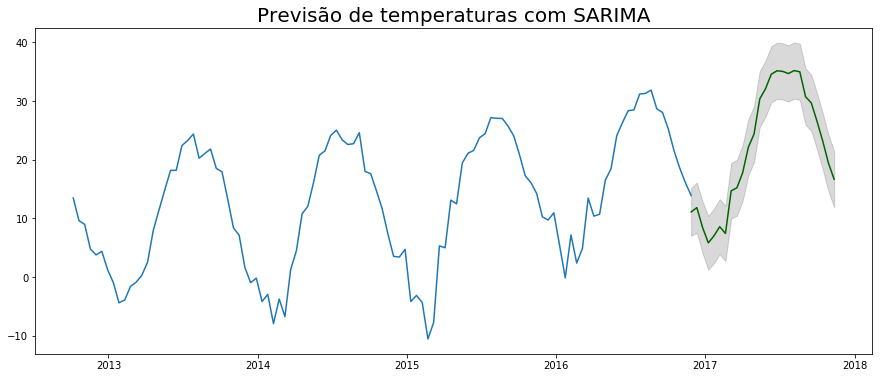

In [282]:
# Forecast
fitted, confint = smodel.predict(n_periods=periodos_ano, return_conf_int=True)
index_of_fc = pd.date_range(data.index[-1], periods=periodos_ano, freq=frequencia)

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(ts)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Previsão de temperaturas com SARIMA", fontsize=20)
plt.show()

## Previsão de valores futuros com dados de teste

In [283]:
# obter intervalo de datas para a previsão
primeira_data = ts.index[-1] + 1
ultima_data = pd.Timestamp(test_data.index[-1], freq='M') + 2
print('Intervalo de datas: %s => %s' % (primeira_data, ultima_data))
datas_previsao = pd.date_range(start=primeira_data, end=ultima_data, freq=frequencia)
datas_previsao

Intervalo de datas: 2016-12-11 00:00:00 => 2017-12-31 00:00:00


DatetimeIndex(['2016-12-11', '2016-12-25', '2017-01-08', '2017-01-22',
               '2017-02-05', '2017-02-19', '2017-03-05', '2017-03-19',
               '2017-04-02', '2017-04-16', '2017-04-30', '2017-05-14',
               '2017-05-28', '2017-06-11', '2017-06-25', '2017-07-09',
               '2017-07-23', '2017-08-06', '2017-08-20', '2017-09-03',
               '2017-09-17', '2017-10-01', '2017-10-15', '2017-10-29',
               '2017-11-12', '2017-11-26', '2017-12-10', '2017-12-24'],
              dtype='datetime64[ns]', freq='2W-SUN')

In [284]:
# gerar novos valores a partir do modelo
periodos_previsao = len(datas_previsao)
valores_previstos = smodel.predict(n_periods=periodos_previsao)

In [285]:
# construir dataframe com previsão
df = pd.DataFrame({
    'date': datas_previsao,
    'temperature': valores_previstos
})
df.set_index('date', inplace=True)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28 entries, 2016-12-11 to 2017-12-24
Data columns (total 1 columns):
temperature    28 non-null float64
dtypes: float64(1)
memory usage: 448.0 bytes


,temperature
date,
2016-12-11,11.112154
2016-12-25,11.847746
2017-01-08,8.471440
2017-01-22,5.842920
2017-02-05,7.051620


In [286]:
# inserir na primeira posição os últimos valores de treino
df = (data.iloc[-2:]).append(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30 entries, 2016-11-13 to 2017-12-24
Data columns (total 1 columns):
temperature    30 non-null float64
dtypes: float64(1)
memory usage: 480.0 bytes


In [287]:
# obter intervalo de datas necessário
data_inicio = test_data.index[0]
data_final = test_data.index[-1]
print('Intervalo necessário:', data_inicio, '=>', data_final)

Intervalo necessário: 2016-11-17 00:00:00 => 2017-11-29 00:00:00


In [288]:
# interpolar dados para obter valores diários
pred_data = df.resample('D').interpolate(method='cubic')

# restringir ao intervalo de datas esperado
pred_data = pred_data[data_inicio:data_final]

# converter temperaturas novamente para graus Celsius
#pred_data['temperature'] -= 273.15

# exibir informações do dataframe
pred_data.info()
pred_data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 378 entries, 2016-11-17 to 2017-11-29
Freq: D
Data columns (total 1 columns):
temperature    378 non-null float64
dtypes: float64(1)
memory usage: 5.9 KB


,temperature
date,
2016-11-17,16.015441
2016-11-18,15.904904
2016-11-19,15.764231
2016-11-20,15.596420
2016-11-21,15.404469


## Geração do arquivo de resultados

In [293]:
# gravar arquivo CSV com os resultados
nome_arquivo = 'weather-submission-arima-' + frequencia + '.csv'
pred_data.to_csv(nome_arquivo)
print('Arquivo gravado com sucesso:', nome_arquivo)

Arquivo gravado com sucesso: weather-submission-arima-2W.csv


In [294]:
# persistir em arquivo Pickle o modelo preditivo
nome_arquivo = 'weather-model-' + frequencia + '.pickle'
pickle.dump(smodel, open(nome_arquivo, 'wb'))
print('Arquivo gravado com sucesso:', nome_arquivo)

Arquivo gravado com sucesso: weather-model-2W.pickle


## Comparação da previsão com dados reais

In [289]:
# carregar dados reais
real_data = pd.read_csv(prefixo_arquivos + 'weather-solution.csv', index_col='date', parse_dates=['date'])
real_data.head()

,temperature
date,
2016-11-17,13.760203
2016-11-18,21.451060
2016-11-19,13.059696
2016-11-20,8.178332
2016-11-21,6.044745


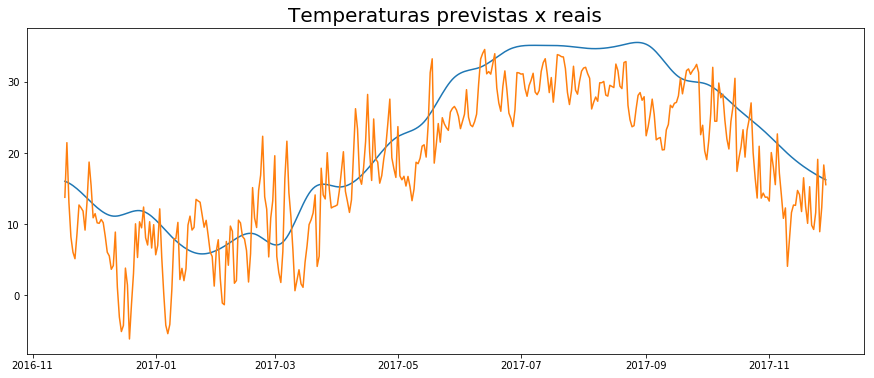

In [290]:
# comparação com os dados reais
plt.plot(pred_data)
plt.plot(real_data)
plt.title('Temperaturas previstas x reais', fontsize=20)
plt.show()

### Medição do escore: RMSE

In [291]:
def rmse(predictions, targets):
    assert len(predictions) == len(targets)
    return np.sqrt(np.mean((predictions - targets) ** 2))

def rmsle(predictions, targets):
    assert len(predictions) == len(targets)
    return np.sqrt(np.mean((np.log(1 + predictions) - np.log(1 + targets)) ** 2))

In [292]:
print('RMSE:', rmse(pred_data['temperature'], real_data['temperature']))

RMSE: 6.194019977115159
